# CTU consult efficiency over time

In [1]:
###################################
#                                 #
#  CTU_efficiency notebook        #
#  Akhil Garg, akhil@akhilgarg.ca #
#  Created 2021-03-20             #
#                                 #
###################################

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import scipy.stats       as stats
import openpyxl
from   tqdm import tqdm

## Data import and cleaning

In [2]:
# Import data
# CTU_efficiency_consults is the source excel workbook with the consults sheet exported
CTU_data = pd.read_csv('CTU_efficiency_consults.csv')
# CTU_data = pd.read_csv('CTU_efficiency_consults.csv', nrows = 500) #testing with smaller amounts of data

# Delete unnecessary columns
unnecessary_columns = ['BIRTHDATE','ADMISSIONDATETIME','DISCHARGEDATETIME', 
                       'RegistrationVisitDateTime',
                       'InstitutionNumber','InstitutionNumberDesc', 
                       'ConsultNumber','ConsultNumber',
                       'PROVIDER_NAME','MEDICAL_RECORD_NUMBER',
                       'DischargeDisposition','DischargeDispositionDesc',
                       'ConsultNumberDesc','ConsultArrivalDateTime']
CTU_data = CTU_data.drop(unnecessary_columns,axis = 1)


# Drop rows in which there was potential confusion about who should admit
# i.e. Internal Medicine was the first (1) and only consulted service
# by the ED
CTU_data = CTU_data[CTU_data['ConsultOccurrence'] == 1]
CTU_data = CTU_data.drop('ConsultOccurrence',axis=1)
      
CTU_data = CTU_data[CTU_data['ConsultServiceDesc'] == 'Internal Medicine']
CTU_data = CTU_data.drop('ConsultServiceDesc',axis=1)

# Delete rows of patients admitted to K2ICU
CTU_data = CTU_data[~CTU_data['LOC'].str.startswith('K2ICU')]

# Convert dates and times from strings to datetime objects
datetime_columns = ['ADMISSION_DATE_TIME','DISCHARGE_DATE_TIME', 'ConsultRequestDateTime']
for column in datetime_columns: CTU_data[column] = pd.to_datetime(CTU_data[column])
    
# Drop rows in which the ConsultRequestDateTime does not have a time
CTU_data = CTU_data[~(CTU_data['ConsultRequestDateTime'].dt.strftime('%H:%M')=='00:00')]
    
# Convert NAME data to mortality data, 
# and convert discharge codes to True/False for death in hospital
CTU_data = CTU_data.rename({'NAME':'Death'}, axis = 1)
CTU_data['Death'] = CTU_data['Death'].apply(lambda x: True if x == 'expired' else False)

# Sort by admission date rather than CTU team
CTU_data = CTU_data.sort_values(by='ADMISSION_DATE_TIME')

# Reindex from 0
CTU_data = CTU_data.reset_index(drop=True)

## Function to format plots

In [3]:
def plot_consistency(ax):
    '''
    Given a matplotlib axes object
    Formats the plot and adds shading for notable CTU events
    '''
    
    # Format the x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = [1,7])) #major ticks qJan/Jul
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) #display month+year as text
    ax.xaxis.set_minor_locator(mdates.MonthLocator()) #minor ticks qmonth
    ax.grid(True)

    # Add vertical lines for bolus to drip transition
    ax.axvline(pd.to_datetime('2018-07-01'),
               color='C1',
               label='bolus to drip transition')

    # Add shaded areas for CTU-G
    ylims = ax.get_ylim()
    G_color='C4'

    ax.fill_betweenx(y=ylims,
                     x1=pd.to_datetime('2017-01-01'),
                     x2=pd.to_datetime('2017-03-16'),
                     alpha=0.2,
                     color=G_color,
                     label='existence of CTU-G')
    ax.fill_betweenx(y=ylims,
                     x1=pd.to_datetime('2018-01-07'),
                     x2=pd.to_datetime('2018-04-08'),
                     alpha=0.2,
                     color=G_color)
    ax.fill_betweenx(y=ylims,
                     x1=pd.to_datetime('2018-09-06'),
                     x2=pd.to_datetime(max(dates)),
                     alpha=0.2,
                     color=G_color)

    ax.legend()
    
    return None

## Baseline Demographics

In [4]:
print('Total population: {}'.format(len(CTU_data.index)))
print('Mean age:         {:.1f}'.format(CTU_data['AGE'].mean()))
male_fraction = CTU_data[(CTU_data['SEX']=='Male')]['SEX'].count()/len(CTU_data.index)
print('% male:           {:.1%}'.format(male_fraction))

Total population: 20257
Mean age:         67.7
% male:           48.9%


## Time between ED's consult request and Medicine's admission

In [5]:
CTU_data['consult_duration'] = CTU_data['ADMISSION_DATE_TIME'] - CTU_data['ConsultRequestDateTime']

# Convert timeDelta objects into hours
CTU_data['consult_duration_hours'] = CTU_data['consult_duration'].dt.total_seconds()/3600

# Basic validation: remove extreme values
# Consults less than 12 minutes (0.2 hours) seem to be an artifact of the data entry
# Consults longer than 72 hours appear to also be artifacts
# CTU_data = CTU_data[(CTU_data['consult_duration_hours'] > 0.2) & (CTU_data['consult_duration_hours'] < 72)]
CTU_data = CTU_data[(CTU_data['consult_duration'] > pd.Timedelta('12min'))]

# Display only 2 decimal places
pd.options.display.float_format = "{:,.2f}".format

# Descriptive data of all consult durations
print('Descriptive data of all times to admission (hours):')
CTU_data['consult_duration_hours'].describe()

Descriptive data of all times to admission (hours):


count   20,100.00
mean         4.88
std          2.50
min          0.22
25%          3.25
50%          4.41
75%          5.92
max         33.17
Name: consult_duration_hours, dtype: float64

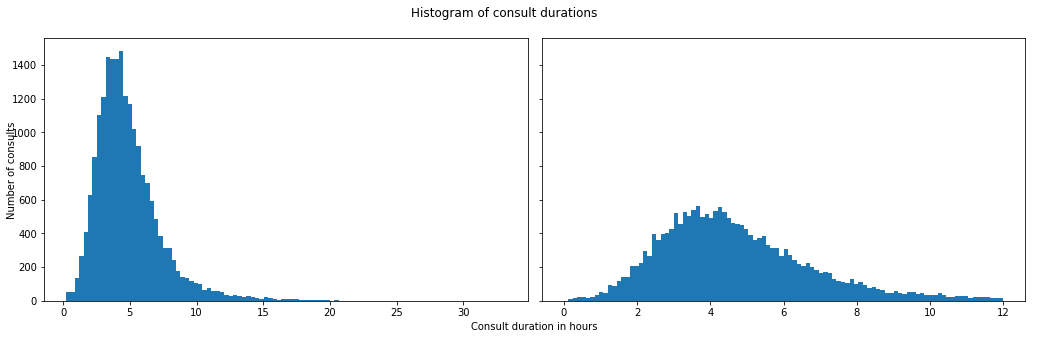

In [6]:
# Plot histogram of consult durations

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, 
                               sharey = True,
                               figsize = (15,5))

fig.suptitle('Histogram of consult durations')

# Extra code to ensure formatting of common axes
fig.add_subplot(111,frameon = False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Consult duration in hours')
plt.ylabel('Number of consults')

# Plot data with sub-ranges
ax1.hist(CTU_data['consult_duration_hours'], bins = 100)                 #full range
ax2.hist(CTU_data['consult_duration_hours'], bins = 100, range = (0,12)) #exclude greater than 12 hours

plt.tight_layout() #otherwise axes overlap
plt.show()

In [7]:
# Group consult durations by day and calculate means and SDs
daily_group = CTU_data.groupby(pd.Grouper(key = 'ADMISSION_DATE_TIME', freq = '24h'))
daily_means = daily_group.mean()['consult_duration_hours']

# Collect list of dates to plot later
dates = [i for i,j in daily_group]

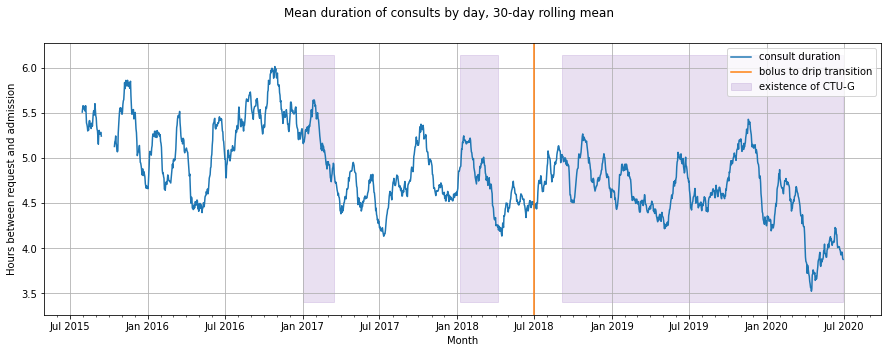

In [8]:
# Plot consult duration over time, grouping by day

fig, ax = plt.subplots(figsize=(15,5))

rolling_average_days = 30

# Add chart labels
fig.suptitle('Mean duration of consults by day, ' +
             '{}-day rolling mean'.format(rolling_average_days))
plt.xlabel('Month')
plt.ylabel("Hours between request and admission")

# Plot data
ax.plot(dates, 
        daily_means.rolling(rolling_average_days).mean(),
        label='consult duration')

plot_consistency(ax)

plt.show()

## CTU team sizes per day

### Calculate readmissions

In [9]:
pd.options.mode.chained_assignment = None

# Add a column for 30-day readmission data
CTU_data.loc[:,'Readmission'] = False

# Group all MRNs together to find readmisions
readmission_frame = CTU_data.groupby('ChartNumber',sort=False) \
    [['ADMISSION_DATE_TIME','DISCHARGE_DATE_TIME']].agg(list)

for MRN in readmission_frame.itertuples():
    # Generates tuples of 
    #(index,admissions_timestamp_list,discharges_timestamp_list)
    
    # Skip MRNs that are not readmissions
    if len(MRN[1]) == 1: continue
        
    # Iterate over all admissions for a given MRN
    for i in range(len(MRN[1]) - 1):
        
        # Calculate admit time at second date (i+1)
        # And subtract previous discharge time (MRN[2](i))
        dc_admit_time =  MRN[1][i+1] - MRN[2][i]

        # Only keep readmissions less than 30 days
        if dc_admit_time < pd.Timedelta('30D'): 
            
            # Write readmision to CTU_data
            row = (CTU_data['ChartNumber']==MRN[0]) & \
                  (CTU_data['ADMISSION_DATE_TIME']==MRN[1][i+1])
            
            CTU_data.loc[row,'Readmission'] = True

# Print all readmissions
CTU_data[CTU_data['Readmission']]

,RESIDENTSERVICE,ADMISSION_DATE_TIME,DISCHARGE_DATE_TIME,VISIT_NUMBER,LOC,SEX,AGE,Death,EncounterNumber,ChartNumber,ConsultRequestDateTime,consult_duration,consult_duration_hours,Readmission
104,Internal Medicine C,2015-07-13 14:27:00,2015-07-15 16:05:00,1159006548,C972-1,Male,77.71,False,"1,151,017,324.00","567,454.00",2015-07-13 09:38:00,0 days 04:49:00,4.82,True
120,Internal Medicine C,2015-07-14 08:35:00,2015-07-19 16:21:00,1159006607,C976-3,Female,76.98,False,"1,151,017,516.00","948,838.00",2015-07-14 04:27:00,0 days 04:08:00,4.13,True
122,Internal Medicine B,2015-07-14 13:23:00,2015-07-18 08:19:00,1159006623,C380-2,Male,38.29,False,"1,151,017,532.00","303,437.00",2015-07-14 08:57:00,0 days 04:26:00,4.43,True
136,Internal Medicine E,2015-07-16 08:16:00,2015-07-16 18:15:00,1159006760,C381-1,Female,71.14,True,"1,151,017,849.00","35,562.00",2015-07-16 06:43:00,0 days 01:33:00,1.55,True
146,Internal Medicine E,2015-07-18 00:45:00,2015-07-20 17:18:00,1159006872,C362-1,Female,55.45,False,"1,151,018,012.00","442,532.00",2015-07-17 16:53:00,0 days 07:52:00,7.87,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220,Internal Medicine C,2020-06-26 23:08:00,2020-07-13 12:56:00,1209004967,K915-2,Female,74.84,False,"1,201,012,552.00","338,564.00",2020-06-26 19:59:00,0 days 03:09:00,3.15,True
20225,Internal Medicine E,2020-06-27 09:06:00,2020-06-30 16:49:00,1209004983,C371-1,Male,48.12,False,"1,201,012,596.00","444,774.00",2020-06-27 06:04:00,0 days 03:02:00,3.03,True
20234,Internal Medicine A,2020-06-28 09:31:00,2020-07-02 17:38:00,1209005023,D4IC04-1,Male,66.35,False,"1,201,012,755.00","978,653.00",2020-06-28 06:33:00,0 days 02:58:00,2.97,True
20237,Internal Medicine D,2020-06-28 15:42:00,2020-06-30 14:23:00,1209005036,K1003-1,Male,79.87,False,"1,201,012,769.00","316,658.00",2020-06-28 11:00:00,0 days 04:42:00,4.70,True


### Reformat data to be grouped by date

In [10]:
# Create a list of dates and a time of day as a cutoff

first_date  = str(CTU_data['ADMISSION_DATE_TIME'].min().date())
last_date   = str(CTU_data['ADMISSION_DATE_TIME'].max().date())
time_of_day = '08:00'

print('Date range: {} to {}, using {} as the time cutoff.'.format(first_date, last_date, time_of_day))

# Create a list of 24-hour periods
date_list   = pd.date_range(start = first_date + ' ' + time_of_day, 
                            end   = last_date  + ' ' + time_of_day,
                            freq  = 'D')

# Create a data frame of dates as index, 
# and change in the size of each CTU team on that date in columns 
CTU_letters = ['A','B','C','D','E','G']
CTU_teams   = ['Internal Medicine {}'.format(letter) for letter in CTU_letters]
date_frame2 = pd.DataFrame(index = date_list, columns = CTU_teams)

# Create a data frame of dates and team name as index, 
# and number of admits and discharges and other values as columns
date_frame = pd.DataFrame(index = date_list, columns = CTU_teams)
date_frame = date_frame.melt(var_name = 'team', ignore_index = False)
date_frame[['admits','dischs','deaths','readmits']] = 0
date_frame = date_frame.drop('value', axis = 1)
date_frame = date_frame.set_index(['team'], append = True)
date_frame = date_frame.rename_axis(['date','team'])

Date range: 2015-07-01 to 2020-06-30, using 08:00 as the time cutoff.


In [11]:
def count_within_date(date, team, adm_or_dc_date, df = CTU_data):
    '''
    Given a date, a resident service (team), 
    and an option of admission or discharge date,
    
    Arguments:
    - date, in pandas datetime format
    - team, a string e.g. 'Internal Medicine B'
    - adm_or_dc_date, in pandas datetime format
    - df, a pandas dataframe to loop over
    
    Returns: 
    
    A pandas series of boolean values. 
    The length of the series is the length of CTU_data
    True if the admission or discharge occurs for the particular team
    in the span (date - 24 hours, date]
    '''
    
    return ((CTU_data['RESIDENTSERVICE'] == team) &
            (CTU_data[adm_or_dc_date]    >  date) &
            (CTU_data[adm_or_dc_date]    <= date + pd.DateOffset(hours=24)))
    
# Fill in date_frame with CTU team, number of admits and discharges, and deaths and readmits
for date in tqdm(date_list):
    
    for team in CTU_teams: 
        
        admits = count_within_date(date = date, team = team,
                                   adm_or_dc_date = 'ADMISSION_DATE_TIME').sum()
        dischs = count_within_date(date = date, team = team,
                                   adm_or_dc_date = 'DISCHARGE_DATE_TIME').sum()
        deaths = ((count_within_date(date = date, team = team,
                                     adm_or_dc_date = 'DISCHARGE_DATE_TIME')) &
                                    (CTU_data['Death'])).sum()
        readmits=((count_within_date(date = date, team = team,
                                     adm_or_dc_date = 'ADMISSION_DATE_TIME')) &
                                    (CTU_data['Readmission'])).sum() 
                             
        date_frame.loc[(date,team)]['admits'] = admits
        date_frame.loc[(date,team)]['dischs'] = dischs
        date_frame.loc[(date,team)]['deaths'] = deaths
        date_frame.loc[(date,team)]['readmits'] = readmits

date_frame['net_change'] = date_frame['admits'] - date_frame['dischs']

100%|██████████████████████████████████████████████████████████████████████████████| 1827/1827 [01:40<00:00, 18.27it/s]


In [12]:
date_frame

,,admits,dischs,deaths,readmits,net_change
date,team,,,,,
2015-07-01 08:00:00,Internal Medicine A,2,0,0,0,2
2015-07-02 08:00:00,Internal Medicine A,0,0,0,0,0
2015-07-03 08:00:00,Internal Medicine A,4,1,0,0,3
2015-07-04 08:00:00,Internal Medicine A,1,0,0,0,1
2015-07-05 08:00:00,Internal Medicine A,3,0,0,0,3
...,...,...,...,...,...,...
2020-06-26 08:00:00,Internal Medicine G,2,2,0,0,0
2020-06-27 08:00:00,Internal Medicine G,1,0,0,0,1
2020-06-28 08:00:00,Internal Medicine G,0,1,0,0,-1


### Number of admissions per day

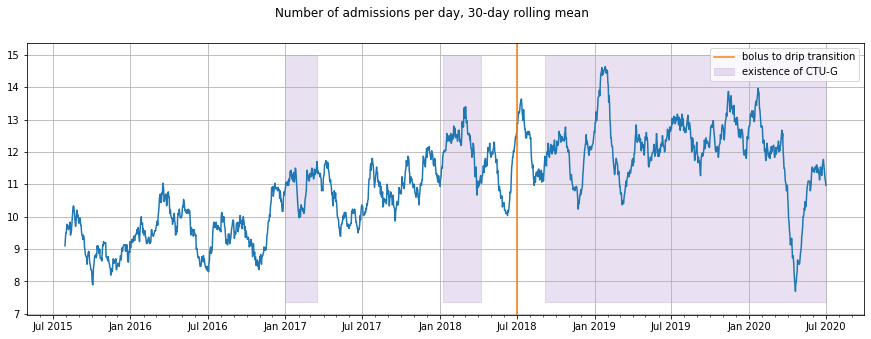

In [13]:
fig, ax = plt.subplots(figsize=(15,5))

plt.suptitle('Number of admissions per day, 30-day rolling mean')

ax.plot(date_frame.unstack()['admits'].sum(axis = 1).rolling(30).mean())

plot_consistency(ax)

plt.show()

### Census size vs. bed allocation

In [14]:
# CTU bed allocations:

# Fiscal years start in April, and allocation per year is hard-coded
allocation_dates = pd.date_range(
         start   = '2014-04-01', 
         freq    = 'BAS-Apr',
         periods = 6)
bed_allocation   = pd.DataFrame(
         index   = allocation_dates,
         data    = [104, 100, 101, 111, 111, 111],
         columns = ['allocation'])

# Approximately 30-35 beds of the allocation go to CTU-H
bed_allocation['minus_CTU_H'] = bed_allocation - 30

bed_allocation

,allocation,minus_CTU_H
2014-04-01,104,74
2015-04-01,100,70
2016-04-01,101,71
2017-04-03,111,81
2018-04-02,111,81
2019-04-01,111,81


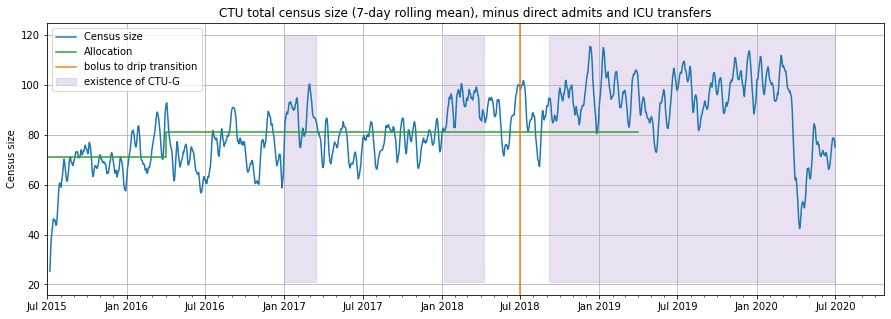

In [15]:
# Create the plot
fig, ax = plt.subplots(figsize=(15,5))

plt.title('CTU total census size (7-day rolling mean), minus direct admits and ICU transfers')
plt.ylabel("Census size")

# Plot data: cumulative sum of daily admits - discharges,
# summed across all CTU teams

ax.plot(date_frame.unstack()['net_change'].sum(axis = 1).cumsum().rolling(7).mean(),
        label = 'Census size'
       )

ax.step(x = bed_allocation.index,
        y = bed_allocation['minus_CTU_H'], 
        label = 'Allocation',
        color = 'C2')

plot_consistency(ax)
ax.set_xlim(CTU_data['ADMISSION_DATE_TIME'].min().date())

plt.show()

### Size of each CTU Team

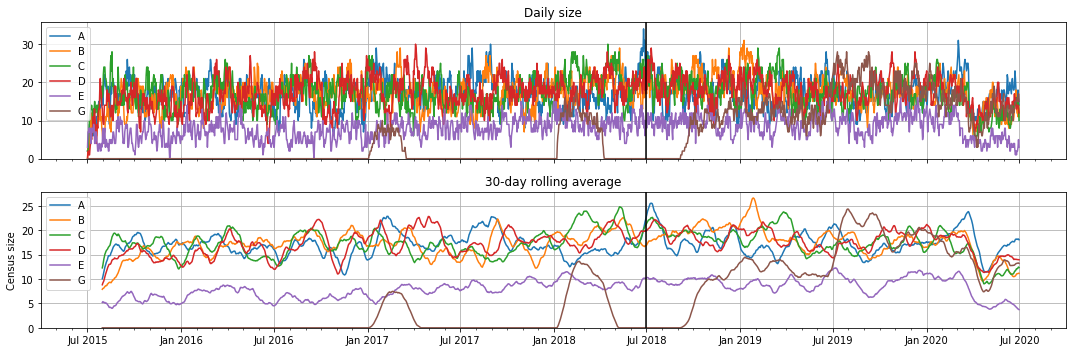

In [16]:
# Make a graph of each CTU team's size over time

fig, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows = 2, sharex = True)

# Add chart labels
#fig.suptitle('CTU team size over time')
plt.ylabel("Census size")

ax1.title.set_text('Daily size')
ax2.title.set_text('30-day rolling average')


# Plot data
ax1.plot(date_frame.unstack()['net_change'].cumsum())
ax2.plot(date_frame.unstack()['net_change'].cumsum().rolling(30).mean())

# Format the x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth = [1,7])) #major ticks qJan/Jul
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) #display month+year as text
ax2.xaxis.set_minor_locator(mdates.MonthLocator()) #minor ticks qmonth

ax1.grid(True)
ax2.grid(True)

# Format the y-axis
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)

for axes in (ax1,ax2):
    # Add vertical lines and shading for notable events
    axes.axvline(pd.to_datetime('2018-07-01'),
               color='black',
               label='bolus to drip transition')
    
# Add a legend
ax1.legend([name[-1] for name in date_frame2.columns])
ax2.legend([name[-1] for name in date_frame2.columns])

plt.tight_layout()
plt.show()

### Size of CTU-G over time

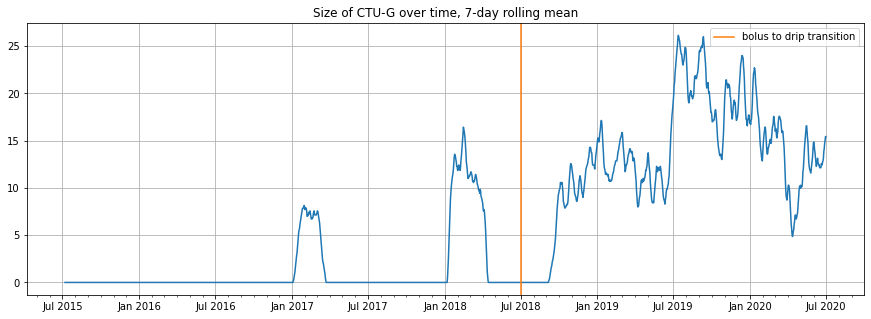

In [17]:
G_size = date_frame.unstack()['net_change']['Internal Medicine G'].cumsum().rolling(7).mean()

fix, ax = plt.subplots(figsize=(15,5))
ax.plot(G_size)

# Format the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = [1,7])) #major ticks qJan/Jul
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) #display month+year as text
ax.xaxis.set_minor_locator(mdates.MonthLocator()) #minor ticks qmonth
ax.grid(True)

# Add vertical lines for notable events
ax.axvline(pd.to_datetime('2018-07-01'),
           color='C1',
           label='bolus to drip transition')

ax.legend()

plt.title('Size of CTU-G over time, 7-day rolling mean')
plt.show()

### Admission and Discharge Rates

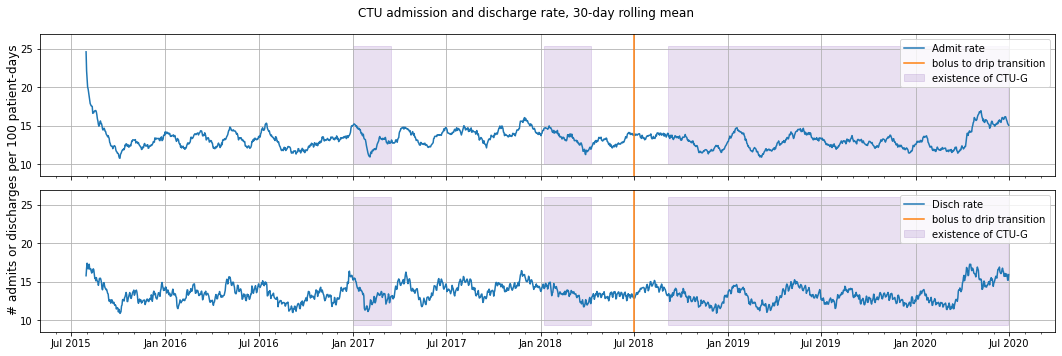

In [18]:
# Calculate census size as the cumulative sum of daily admits-discharges
date_frame['census'] = date_frame.groupby('team')['net_change'].cumsum()
date_frame[date_frame['census'] < 0] = np.nan

# Calculate admission and discharge rates
date_frame['admit_rate'] = date_frame['admits']/date_frame['census']
date_frame['disch_rate'] = date_frame['dischs']/date_frame['census']
date_frame = date_frame.replace(np.inf, np.nan) #avoids divide-by-zero errors

# Define a weighted average function
def wavgdisch(df):
    d = df['disch_rate']
    w = df['census']
    return (d * w).sum() / w.sum()

def wavgadmit(df):
    d = df['admit_rate']
    w = df['census']
    return (d * w).sum() / w.sum()

# Create the plot
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows = 2, sharex = True, sharey = True)

fig.suptitle('CTU admission and discharge rate, 30-day rolling mean')
fig.supylabel("# admits or discharges per 100 patient-days")

# Plot data: cumulative sum of daily admits - discharges,
# multiplied by 100 for 100-patient-days
ax1.plot(date_frame.groupby('date').apply(wavgadmit).rolling(30).mean()*100,label='Admit rate')
ax2.plot(date_frame.groupby('date').apply(wavgdisch).rolling(30).mean()*100,label='Disch rate')

for ax in (ax1,ax2): plot_consistency(ax)

plt.tight_layout()
plt.show()


### Death rates

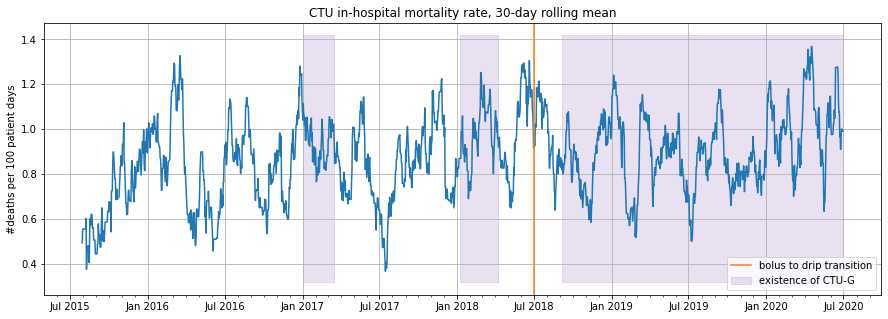

In [19]:
# Calculate death rates
date_frame['death_rate'] = date_frame['deaths']/date_frame['census']
date_frame = date_frame.replace(np.inf, np.nan) #avoids divide-by-zero errors

# Define a weighted average function
def wavgdeath(df):
    d = df['death_rate']
    w = df['census']
    return (d * w).sum() / w.sum()

# Create the plot
fig, ax = plt.subplots(figsize=(15,5))

plt.title('CTU in-hospital mortality rate, 30-day rolling mean')
plt.ylabel("#deaths per 100 patient days")

# Plot data: cumulative sum of daily admits - discharges,
# multiplied by 100 for 100-patient-days
ax.plot(date_frame.groupby('date').apply(wavgdeath).rolling(30).mean()*100)

plot_consistency(ax)

plt.show()

### Length of Stay

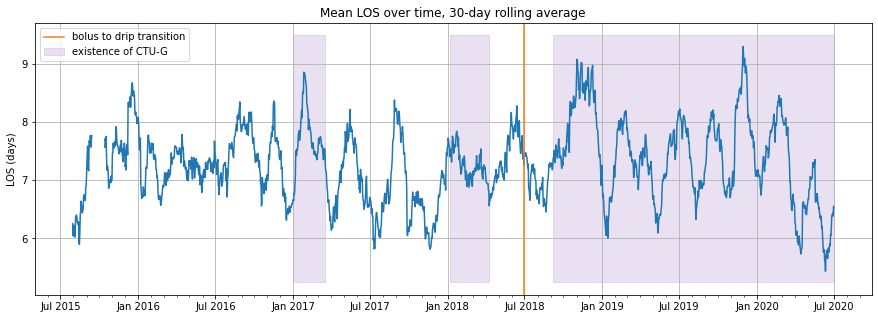

In [20]:
pd.options.mode.chained_assignment = None

CTU_data['LOS'] = CTU_data['DISCHARGE_DATE_TIME'] - CTU_data['ADMISSION_DATE_TIME']
CTU_data['LOS'] = CTU_data['LOS'].dt.total_seconds()/86400

daily_group    = CTU_data.groupby(pd.Grouper(key = 'ADMISSION_DATE_TIME', freq = '24h'))
daily_mean_LOS = daily_group.mean()['LOS']

# Plot data
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(daily_mean_LOS.rolling(30).mean())

# Labels
plt.title('Mean LOS over time, 30-day rolling average')
plt.ylabel('LOS (days)')

plot_consistency(ax)

plt.show()

### Readmission Rate

In [21]:
'''
# Using data from Readmissions.csv, which I have now abandoned due to inconsistencies in the data

# Import and clean data
readmissions = pd.read_csv('Readmissions.csv')
 
# Convert dates and times from strings to datetime objects
datetime_columns = ['ADMISSION_DATE_TIME','DISCHARGE_DATE_TIME','READMISSION_DATE_TIME','REDISCHARGE_DATE_TIME']
for column in datetime_columns: readmissions[column] = pd.to_datetime(readmissions[column])    
    
# Remove duplicates based on visit number (dataset seems to duplicate internal hospital transfers)
readmissions = readmissions.drop_duplicates(subset='VISIT_NUMBER')

# Only keep readmits within 30 days
readmissions = readmissions[(readmissions['READMISSION_DATE_TIME']
                           - readmissions['DISCHARGE_DATE_TIME']) 
                           < pd.Timedelta('30D')]

# Data includes ED holdovers
# Remove patients in ED for less than 24h
readmissions = readmissions[(readmissions['REDISCHARGE_DATE_TIME']
                           - readmissions['READMISSION_DATE_TIME']) 
                           < pd.Timedelta('24h')]

# Fill in date_frame with readmits

for date in tqdm(date_list):
    for team in CTU_teams: 
        
        readmits = readmissions[(readmissions['RESIDENTSERVICE']       == team) &
                                (readmissions['READMISSION_DATE_TIME'] >  date) &
                                (readmissions['READMISSION_DATE_TIME'] <= date + pd.DateOffset(hours=24))]
    
        date_frame.loc[(date,team)]['readmits'] = len(readmits.index)
    
# Calculate readmit rate
date_frame['readmit_rate'] = date_frame['readmits']/date_frame['census']
date_frame = date_frame.replace(np.inf, np.nan) #avoids divide-by-zero errors

print(date_frame)
'''

"\n# Using data from Readmissions.csv, which I have now abandoned due to inconsistencies in the data\n\n# Import and clean data\nreadmissions = pd.read_csv('Readmissions.csv')\n \n# Convert dates and times from strings to datetime objects\ndatetime_columns = ['ADMISSION_DATE_TIME','DISCHARGE_DATE_TIME','READMISSION_DATE_TIME','REDISCHARGE_DATE_TIME']\nfor column in datetime_columns: readmissions[column] = pd.to_datetime(readmissions[column])    \n    \n# Remove duplicates based on visit number (dataset seems to duplicate internal hospital transfers)\nreadmissions = readmissions.drop_duplicates(subset='VISIT_NUMBER')\n\n# Only keep readmits within 30 days\nreadmissions = readmissions[(readmissions['READMISSION_DATE_TIME']\n                           - readmissions['DISCHARGE_DATE_TIME']) \n                           < pd.Timedelta('30D')]\n\n# Data includes ED holdovers\n# Remove patients in ED for less than 24h\nreadmissions = readmissions[(readmissions['REDISCHARGE_DATE_TIME']\n      

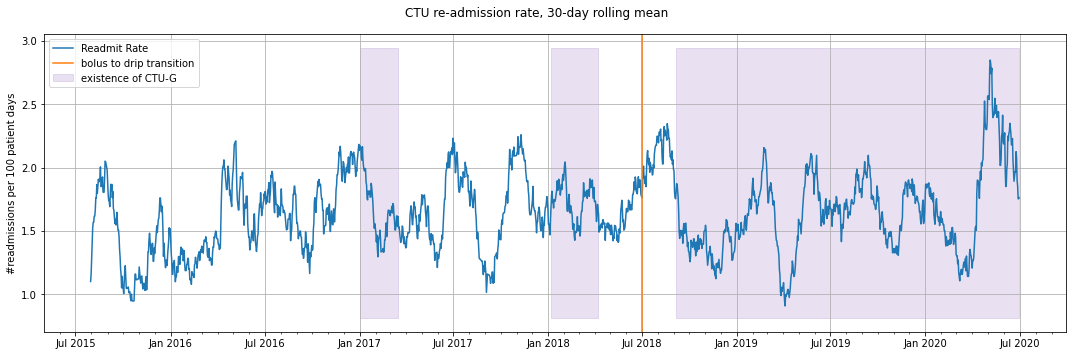

In [22]:
# Calculate readmit rate
date_frame['readmit_rate'] = date_frame['readmits']/date_frame['census']
date_frame = date_frame.replace(np.inf, np.nan) #avoids divide-by-zero errors

# Define a weighted average function
def wavgreadmit(df):
    d = df['readmit_rate']
    w = df['census']
    return (d * w).sum() / w.sum()

# Create the plot
fig, ax = plt.subplots(figsize=(15,5))

fig.suptitle('CTU re-admission rate, 30-day rolling mean')
plt.ylabel("#readmissions per 100 patient days")

# Plot data: cumulative sum of daily admits - discharges,
# multiplied by 100 for 100-patient-days
ax.plot(date_frame.groupby('date').apply(wavgreadmit).rolling(30).mean()*100,label='Readmit Rate')

plot_consistency(ax)

plt.tight_layout()
plt.show()

### Size of CTU-E relative to all other teams

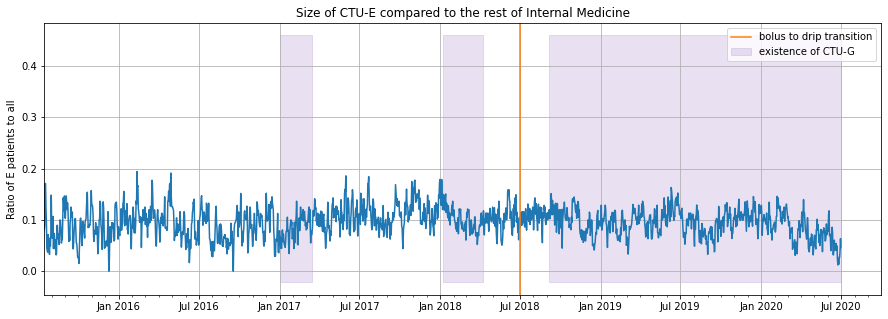

In [23]:
date_frame_combined_teams = pd.DataFrame(index=date_list,
                                         columns=['Combined_census','E_ratio'])
date_frame_combined_teams.index.name = 'Date'

date_frame_combined_teams['Combined_census'] = date_frame.unstack()['census'].sum(axis=1)
date_frame_combined_teams['E_ratio'] = date_frame.unstack()['census']['Internal Medicine E'] / \
    date_frame_combined_teams['Combined_census']

# Plot data
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(date_frame_combined_teams['E_ratio'].rolling(1).mean())

# Labels
plt.title('Size of CTU-E compared to the rest of Internal Medicine')
plt.ylabel('Ratio of E patients to all')

# Format the axes
plot_consistency(ax)
ax.set_xlim(pd.to_datetime('2015-07-15'))

plt.show()

In [24]:
# Reformat so that indexes become columns
date_frame = date_frame.reset_index().sort_values(by=['date','team']).reset_index(drop=True)

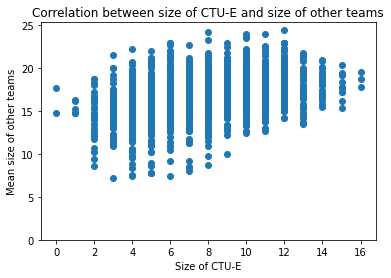

Correlation between size of CTU-E and other teams:
SpearmanrResult(correlation=0.3662889616671779, pvalue=6.824738266376827e-59)


In [25]:
# Correlate the size of CTU-E with the mean census size of all other teams

# Ignore data when CTU-G had zero patients
no_empty_G = date_frame.drop(date_frame[(date_frame['team']=='Internal Medicine G') &
                            (date_frame['census']==0)].index)

# Start date only after 1 week to allow census sizes to re-equilibrate
delayed_no_empty_G = no_empty_G[no_empty_G.date >= pd.to_datetime('2015-07-08')]

# Mean size of other teams
E_correlation = delayed_no_empty_G[delayed_no_empty_G['team']!='Internal Medicine E'] \
    .groupby('date')['census'].mean().to_frame()

# Mean size of E
E_correlation.loc[:,'E_size'] = delayed_no_empty_G[
                                delayed_no_empty_G['team']=='Internal Medicine E']['census'].values

# Combine data into a dataframe
E_correlation = E_correlation.rename(columns={'census':'other_size'})

# Plot the data
plt.scatter(x=E_correlation['E_size'],
            y=E_correlation['other_size'])

plt.title('Correlation between size of CTU-E and size of other teams')
plt.xlabel('Size of CTU-E')
plt.ylabel('Mean size of other teams')
plt.ylim(ymin=0)
plt.show()

print('Correlation between size of CTU-E and other teams:\n{}'.format(stats.spearmanr(E_correlation)))

In [26]:
# Compare size of CTU-E when other teams are busy vs. not

date_frame.loc[date_frame['census']>20,'large_census'] = True
date_frame['large_census'] = date_frame['large_census'].fillna(False)

E_size_list = []

for date, group in date_frame.groupby('date'):
    
    E_size = int(group[group['team']=='Internal Medicine E']['census'])
    E_size_list = E_size_list + ([E_size] * len(group.index))

date_frame.loc[:,'E_size'] = E_size_list

print('On days when at least one team had a census > 20 ' +
      '({:.0f} days), mean CTU-E size was {:.2f}.'.format(
          len(date_frame[date_frame['large_census']].index)/6,
          date_frame[date_frame['large_census']]['E_size'].mean()))

print('On days when all teams had a census < 20 ' +
      '({:.0f} days), mean CTU-E size was {:.2f}.'.format(
          len(date_frame[~date_frame['large_census']].index)/6,
          date_frame[~date_frame['large_census']]['E_size'].mean()))

On days when at least one team had a census > 20 (276 days), mean CTU-E size was 8.76.
On days when all teams had a census < 20 (1551 days), mean CTU-E size was 7.86.


## Write data frames to file

In [27]:
# Delete more unnecessary columns
CTU_data = CTU_data.drop(['VISIT_NUMBER','ChartNumber'],axis=1)

In [28]:
date_frame.to_excel('Daily CTU Census.xlsx')
CTU_data.to_pickle('CTU_data.pickle')
date_frame.to_pickle('Daily CTU Census.pickle')

In [29]:
# Reformat date_frame for statistician

# Remove data after March 15, 2020 (outside of study period)
date_frame = date_frame[date_frame['date']<=pd.to_datetime('2020-03-16')]

# Add a 'Drip?' column for date_frame
date_frame.loc[date_frame['date']>=pd.to_datetime('2018-07-01 08:00'),'drip'] = 1
date_frame.loc[date_frame['date']< pd.to_datetime('2018-07-01 08:00'),'drip'] = 0

# Add a 'G exists?' column for date_frame
date_frame['G_exists'] = ((date_frame['date'] >= pd.to_datetime('2017-01-01 08:00'))  & \
                          (date_frame['date'] <  pd.to_datetime('2017-03-16 08:00'))) | \
                         ((date_frame['date'] >= pd.to_datetime('2018-01-07 08:00'))  & \
                          (date_frame['date'] <  pd.to_datetime('2018-04-08 08:00'))) | \
                          (date_frame['date'] >= pd.to_datetime('2018-09-06 08:00'))
date_frame['G_exists'] = date_frame['G_exists'].replace({True:1,False:0})

# Only keep some columns
date_frame_output = date_frame[['date','team','admits','dischs','net_change','census',
                                'admit_rate','disch_rate','drip','G_exists']]
date_frame_output['drip'] = date_frame_output['drip'].astype(int)

date_frame_output.to_excel('Daily CTU Census 2021-05-28.xlsx',index=False)

In [30]:
date_frame

,date,team,admits,dischs,deaths,readmits,net_change,census,admit_rate,disch_rate,death_rate,readmit_rate,large_census,E_size,drip,G_exists
0,2015-07-01 08:00:00,Internal Medicine A,2.00,0.00,0.00,0.00,2.00,2.00,1.00,0.00,0.00,0.00,False,3,0.00,0
1,2015-07-01 08:00:00,Internal Medicine B,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,False,3,0.00,0
2,2015-07-01 08:00:00,Internal Medicine C,2.00,0.00,0.00,0.00,2.00,2.00,1.00,0.00,0.00,0.00,False,3,0.00,0
3,2015-07-01 08:00:00,Internal Medicine D,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,False,3,0.00,0
4,2015-07-01 08:00:00,Internal Medicine E,3.00,0.00,0.00,0.00,3.00,3.00,1.00,0.00,0.00,0.00,False,3,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,2020-03-15 08:00:00,Internal Medicine B,3.00,0.00,0.00,0.00,3.00,23.00,0.13,0.00,0.00,0.00,True,5,1.00,1
10316,2020-03-15 08:00:00,Internal Medicine C,2.00,0.00,0.00,1.00,2.00,19.00,0.11,0.00,0.00,0.05,False,5,1.00,1
10317,2020-03-15 08:00:00,Internal Medicine D,2.00,0.00,0.00,1.00,2.00,17.00,0.12,0.00,0.00,0.06,False,5,1.00,1
10318,2020-03-15 08:00:00,Internal Medicine E,1.00,1.00,0.00,0.00,0.00,5.00,0.20,0.20,0.00,0.00,False,5,1.00,1


# Other calculations

In [31]:
CTU_data.loc[CTU_data['ADMISSION_DATE_TIME']>=pd.to_datetime('2018-07-01 08:00'),'drip'] = 1
CTU_data.loc[CTU_data['ADMISSION_DATE_TIME']< pd.to_datetime('2018-07-01 08:00'),'drip'] = 0

CTU_data

,RESIDENTSERVICE,ADMISSION_DATE_TIME,DISCHARGE_DATE_TIME,LOC,SEX,AGE,Death,EncounterNumber,ConsultRequestDateTime,consult_duration,consult_duration_hours,Readmission,LOS,drip
0,Internal Medicine E,2015-07-01 16:58:00,2015-07-03 16:57:00,C380-2,Female,86.17,False,"1,151,015,270.00",2015-07-01 13:02:00,0 days 03:56:00,3.93,False,2.00,0.00
1,Internal Medicine C,2015-07-01 18:57:00,2015-08-01 11:38:00,K950-1,Male,66.67,False,"1,151,015,278.00",2015-07-01 16:09:00,0 days 02:48:00,2.80,False,30.70,0.00
2,Internal Medicine E,2015-07-01 20:01:00,2015-07-08 09:44:00,C383-1,Female,71.10,False,"1,151,015,302.00",2015-07-01 15:57:00,0 days 04:04:00,4.07,False,6.57,0.00
3,Internal Medicine A,2015-07-01 22:36:00,2015-07-07 14:35:00,C1071-1,Male,71.12,False,"1,151,015,328.00",2015-07-01 18:51:00,0 days 03:45:00,3.75,False,5.67,0.00
4,Internal Medicine E,2015-07-01 23:00:00,2015-07-04 07:07:00,C380-1,Female,43.53,False,"1,151,015,277.00",2015-07-01 12:48:00,0 days 10:12:00,10.20,False,2.34,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20252,Internal Medicine D,2020-06-30 17:42:00,2020-07-03 14:10:00,C364-1,Female,93.06,False,"1,201,013,078.00",2020-06-30 13:01:00,0 days 04:41:00,4.68,False,2.85,1.00
20253,Internal Medicine C,2020-06-30 17:47:00,2020-07-03 17:10:00,C977-3,Female,88.85,False,"1,201,013,067.00",2020-06-30 12:23:00,0 days 05:24:00,5.40,False,2.97,1.00
20254,Internal Medicine D,2020-06-30 19:24:00,2020-07-18 14:15:00,C371-1,Female,58.50,False,"1,201,013,093.00",2020-06-30 14:57:00,0 days 04:27:00,4.45,False,17.79,1.00
20255,Internal Medicine D,2020-06-30 21:39:00,2020-07-10 10:08:00,D4IC13-2,Female,66.97,False,"1,201,013,145.00",2020-06-30 19:27:00,0 days 02:12:00,2.20,False,9.52,1.00


In [32]:
CTU_data[(CTU_data['drip']==1) & (CTU_data['LOC'].str.startswith('D4IC'))]

,RESIDENTSERVICE,ADMISSION_DATE_TIME,DISCHARGE_DATE_TIME,LOC,SEX,AGE,Death,EncounterNumber,ConsultRequestDateTime,consult_duration,consult_duration_hours,Readmission,LOS,drip
11426,Internal Medicine C,2018-07-01 14:55:00,2018-07-04 18:12:00,D4IC13-2,Male,33.78,False,"1,181,016,748.00",2018-07-01 11:46:00,0 days 03:09:00,3.15,False,3.14,1.00
11429,Internal Medicine C,2018-07-01 23:50:00,2018-07-26 14:27:00,D4IC08-2,Female,74.32,False,"1,181,016,863.00",2018-07-01 21:42:00,0 days 02:08:00,2.13,False,24.61,1.00
11439,Internal Medicine B,2018-07-02 17:11:00,2018-07-09 17:26:00,D4IC18-1,Female,84.33,False,"1,181,016,974.00",2018-07-02 13:20:00,0 days 03:51:00,3.85,False,7.01,1.00
11447,Internal Medicine D,2018-07-02 22:39:00,2018-07-13 13:18:00,D4IC05-2,Male,43.21,False,"1,181,017,051.00",2018-07-02 18:00:00,0 days 04:39:00,4.65,False,10.61,1.00
11455,Internal Medicine D,2018-07-03 04:07:00,2018-07-18 15:41:00,D4IC09-1,Female,79.21,False,"1,181,017,120.00",2018-07-03 01:00:00,0 days 03:07:00,3.12,False,15.48,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20217,Internal Medicine G,2020-06-26 17:52:00,2020-07-10 15:40:00,D4IC08-2,Male,58.73,False,"1,201,012,487.00",2020-06-26 13:25:00,0 days 04:27:00,4.45,False,13.91,1.00
20218,Internal Medicine B,2020-06-26 22:03:00,2020-06-30 20:20:00,D4IC09-1,Male,53.40,False,"1,201,012,531.00",2020-06-26 19:12:00,0 days 02:51:00,2.85,False,3.93,1.00
20219,Internal Medicine A,2020-06-26 22:32:00,2020-07-01 15:17:00,D4IC03-1,Female,72.27,False,"1,201,012,548.00",2020-06-26 19:32:00,0 days 03:00:00,3.00,False,4.70,1.00
20234,Internal Medicine A,2020-06-28 09:31:00,2020-07-02 17:38:00,D4IC04-1,Male,66.35,False,"1,201,012,755.00",2020-06-28 06:33:00,0 days 02:58:00,2.97,True,4.34,1.00
